# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### Instantiation of an Agent object

In [6]:
from ppo_agent import *
buffer_size = 2048
batch_size = 64 
num_epochs = 10
hidden_units = 512
learn_rate = 1e-3
agent = Agent(state_size, action_size, buffer_size, batch_size, num_epochs, hidden_units, learn_rate)

### Training the agent

In [7]:
import torch
from collections import deque
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def ppo(print_every=10): 
    episode = 0
    epsilon = 0.2
    all_the_scores = []
    last_scores = deque(maxlen=100) 
    while True:
        episode += 1
        agent_scores = []
        # Collecting trajectory for learning 
        results = collect_trajectories(env, brain_name, agent, num_agents)
        # Looping over agents
        for result in results:
            states, actions, log_probs, returns, advant, values, score = result
            agent_scores.append(score)
            # Computing losses and updating policy for current agent
            agent.perform_learning_with(states, actions, log_probs, returns, advant, values, epsilon)
        epsilon*=0.999  #the clipping parameter reduces as time goes on
        max_score = np.max(agent_scores)
        last_scores.append(max_score)
        all_the_scores.append(max_score)
        mean_score = np.mean(last_scores)
        if episode>=100 and mean_score >= 0.5:
            print(' \nTraining over !\t The environment have been solved in ',episode,' episodes ... \n')
            print('with a mean (over agents and last 100 episodes) score of {:.2f}'.format(mean_score))
            torch.save(agent.policy.state_dict(),'checkpoint_actor.pth')
            torch.save(agent.critic.state_dict(), 'checkpoint_critic.pth')    
            with open('agent_scores.pickle', 'wb') as file:
                pickle.dump(all_the_scores, file)
            return all_the_scores
        elif episode % print_every == 0:    
            print ('\rEpisode n°{}\t Mean score = {:.2f}'.format(episode, mean_score), end='\n')
        else:
            print('\rEpisode n°{}\t Mean score = {:.2f}'.format(episode, mean_score), end="")
    return all_the_scores

In [9]:
from workspace_utils import active_session
with active_session():
    scores = ppo()

/home/workspace/ppo_agent.py:136: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic.parameters(), 1)
/home/workspace/ppo_agent.py:141: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.policy.parameters(),5)


Episode n°10	 Mean score = 1.66
Episode n°20	 Mean score = 2.33
Episode n°30	 Mean score = 2.78
Episode n°40	 Mean score = 2.93
Episode n°50	 Mean score = 3.09
Episode n°60	 Mean score = 3.25
Episode n°70	 Mean score = 3.37
Episode n°80	 Mean score = 3.45
Episode n°90	 Mean score = 3.55
Episode n°99	 Mean score = 3.56 
Training over !	 The environment have been solved in  100  episodes ... 

with a mean (over agents and last 100 episodes) score of 3.57


### Evolution of performance

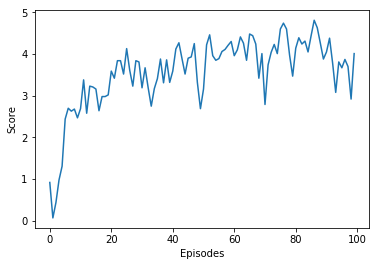

In [10]:
with open('agent_scores.pickle', 'rb') as file:
    all_the_scores = pickle.load(file)
    fig=plt.figure()
    ax=fig.add_subplot(111)
    plt.plot(np.arange(len(all_the_scores)),all_the_scores)
    plt.ylabel('Score')
    plt.xlabel('Episodes')
    plt.savefig('Performance')
    plt.show()